# Predicting Pathogen from RNAseq data

## Create the model using hyperparameter tuning

Training set has 99 samples. Testing set has 43 samples.
Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   46.4s finished


Best: -1.313247 using {'n_estimators': 7, 'max_depth': 2}
-1.359561 (0.002301) with: {'n_estimators': 1, 'max_depth': 2}
-1.332849 (0.012278) with: {'n_estimators': 3, 'max_depth': 2}
-1.326635 (0.017019) with: {'n_estimators': 5, 'max_depth': 2}
-1.313247 (0.017527) with: {'n_estimators': 7, 'max_depth': 2}
-1.321541 (0.022684) with: {'n_estimators': 9, 'max_depth': 2}
-1.360918 (0.000564) with: {'n_estimators': 1, 'max_depth': 4}
-1.336042 (0.008165) with: {'n_estimators': 3, 'max_depth': 4}
-1.337598 (0.027781) with: {'n_estimators': 5, 'max_depth': 4}
-1.338183 (0.034502) with: {'n_estimators': 7, 'max_depth': 4}
-1.339095 (0.041565) with: {'n_estimators': 9, 'max_depth': 4}
-1.360918 (0.000564) with: {'n_estimators': 1, 'max_depth': 6}
-1.336042 (0.008165) with: {'n_estimators': 3, 'max_depth': 6}
-1.337598 (0.027781) with: {'n_estimators': 5, 'max_depth': 6}
-1.338183 (0.034502) with: {'n_estimators': 7, 'max_depth': 6}
-1.339095 (0.041565) with: {'n_estimators': 9, 'max_depth': 

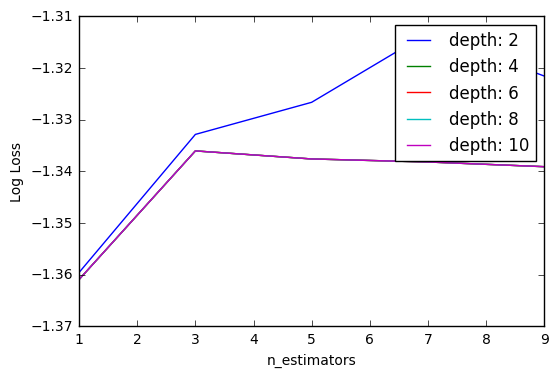

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

patient_groups=["control", "viral", "bacterial", "fungal"]
group_id = lambda name: patient_groups.index(name)

X = pd.DataFrame.from_csv("combineSV_WTcpmtable_v2.txt", sep="\s+").T
y = [group_id("bacterial")] * 29 \
    + [group_id("viral")] * 42 \
    + [group_id("fungal")] * 10 \
    + [group_id("control")] * 61
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print "Training set has %d samples. Testing set has %d samples." % (len(X_train), len(X_test))

model = XGBClassifier(objective="multi:softprob")
# Number of boosted trees to fit.
n_estimators = range(1, 11, 2)
# Maximum tree depth for base learners.
max_depth = range(2, 11, 2)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", 
                           n_jobs=1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
%matplotlib inline

scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')

None


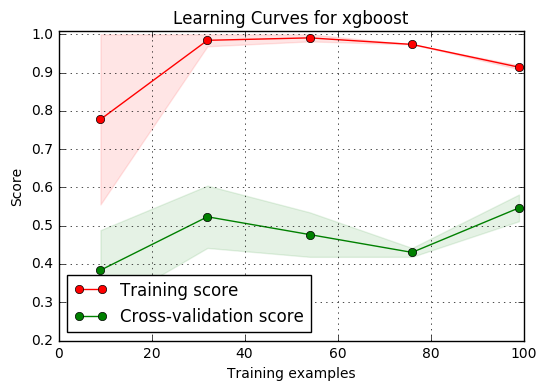

In [2]:
%matplotlib inline
from learning_curves import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

best_estimator = XGBClassifier(**grid_search.best_params_)

title = "Learning Curves for xgboost"
cv = ShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
plot_learning_curve(best_estimator, title, X, y, (0.2, 1.01), cv=cv, n_jobs=1)
plt.show()

## Make predictions based on the model

In [3]:
# make predictions
predicted = grid_result.predict(X_test)

print "Accuracy was %.2f%%\n" % (100 * accuracy_score(y_test, predicted))
print classification_report(y_test, predicted, target_names=patient_groups)
cm = confusion_matrix(y_test, predicted, labels=range(len(patient_groups)))
print "Confusion Matrix: rows = predictions, columns = actual\n"
row_format ="{:>15}" * (len(patient_groups)+1)
print row_format.format("", *patient_groups)
for disease, row in zip(patient_groups, cm):
    print row_format.format(disease, *row)

Accuracy was 51.16%

             precision    recall  f1-score   support

    control       0.64      0.74      0.68        19
      viral       0.30      0.27      0.29        11
  bacterial       0.56      0.50      0.53        10
     fungal       0.00      0.00      0.00         3

avg / total       0.49      0.51      0.50        43

Confusion Matrix: rows = predictions, columns = actual

                       control          viral      bacterial         fungal
        control             14              2              3              0
          viral              6              3              1              1
      bacterial              1              3              5              1
         fungal              1              2              0              0


## Review patients the model misclassified

In [4]:
probs = np.array(grid_result.predict_proba(X_test))
probs *= 100

d = {"Probability Control": probs[:, patient_groups.index("control")],
     "Probability Viral": probs[:, patient_groups.index("viral")],
     "Probability Bacterial": probs[:, patient_groups.index("bacterial")],
     "Predicted Class": [patient_groups[i] for i in grid_result.predict(X_test)],
     "Actual Class": [patient_groups[i] for i in y_test]}

patient_df = pd.DataFrame(d, index=X_test.index)
patient_df[patient_df["Predicted Class"] != patient_df["Actual Class"]]

,Actual Class,Predicted Class,Probability Bacterial,Probability Control,Probability Viral
MNC.014,viral,control,23.392109,30.087852,24.744411
MNC.674,viral,control,22.655106,34.055008,27.102434
MNC.098,viral,control,14.892682,37.064793,33.956825
MN_223,bacterial,control,22.889997,29.844179,25.616163
MNC.292,control,bacterial,29.759371,23.411911,27.948860
MNC.131,control,bacterial,31.754002,25.190596,24.783957
MN_326,control,viral,20.577374,24.134228,35.826050
MNC.452.x,bacterial,viral,19.016665,29.888338,33.108788
MNC.412,viral,fungal,13.519282,23.623735,22.788357
MN_368,control,bacterial,34.392048,24.539768,21.278799


In [5]:
from IPython.core.display import display, HTML

colname = "Importance"
df = pd.DataFrame(grid_result.best_estimator_.booster().get_score(importance_type="weight"),
                  index=[colname]).T
df = df[df[colname] > 0]
df = df.sort_values(by=[colname], ascending=False)

s="""
<h2>List of genes by importance</h2>
<p>Note: the NCBI link will open the target in a new window or tab.</p>
<table>
<tr><th>Gene</th><th>Importance</th><th>NCBI</th></tr>
"""

ncbi_url = lambda gene: "https://www.ncbi.nlm.nih.gov/gene/?term=%s[Gene Name] AND Human[Organism]" % (gene)

for index, row in df.iterrows():
    s += """
    <tr><td>%s</td><td>%d</td>
    <td><a target=\"_blank\" href=\"%s\">NCBI Search</a></td></tr>
    """ %(index, row[0], ncbi_url(index))
s += "</table>"

display(HTML(s))


Gene,Importance,NCBI
RHCE,7,NCBI Search
SDC4,4,NCBI Search
PTGES3,4,NCBI Search
PABPC1,4,NCBI Search
MOBP,4,NCBI Search
BAZ1B,4,NCBI Search
CAMK1,4,NCBI Search
LINC01247,4,NCBI Search
ABAT,3,NCBI Search
CARD11,3,NCBI Search


In [6]:
# Dump booster info
print grid_result.best_estimator_.base_score
print "\n".join(grid_result.best_estimator_.booster().get_dump())

0.5
0:[PABPC1<2108.71] yes=1,no=2,missing=1
	1:[PTGES3<90.9317] yes=3,no=4,missing=3
		3:leaf=-0.0248649
		4:leaf=0.115789
	2:[MOBP<129.057] yes=5,no=6,missing=5
		5:leaf=0.164045
		6:leaf=-0.0352941

0:[CARD11<115.479] yes=1,no=2,missing=1
	1:[RPSA<3.21717] yes=3,no=4,missing=3
		3:leaf=0.0513274
		4:leaf=-0.0434783
	2:[ABCA5<20.3476] yes=5,no=6,missing=5
		5:leaf=0.157895
		6:leaf=0.0117647

0:[LINC01247<0.844941] yes=1,no=2,missing=1
	1:[LOC101929567<349.976] yes=3,no=4,missing=3
		3:leaf=-0.0540773
		4:leaf=0.0956522
	2:[CAMK1<10.0913] yes=5,no=6,missing=5
		5:leaf=0.163636
		6:leaf=-0.0482759

0:[RHCE<37.9593] yes=1,no=2,missing=1
	1:[ACP1<248.937] yes=3,no=4,missing=3
		3:leaf=-0.0647273
		4:leaf=0.0588235
	2:[A1CF<30.3216] yes=5,no=6,missing=5
		5:leaf=0.12
		6:leaf=0.0117647

0:[PABPC1<2108.71] yes=1,no=2,missing=1
	1:[PTGES3<90.9317] yes=3,no=4,missing=3
		3:leaf=-0.0240633
		4:leaf=0.103782
	2:[MOBP<129.057] yes=5,no=6,missing=5
		5:leaf=0.140908
		6:leaf=-0.0348951

0:[SDC4<

In [7]:
idf = X_test.loc[:, df.index.tolist()].copy()
idf["group"] = [patient_groups[idx] for idx in y_test]
idf

,RHCE,SDC4,PTGES3,PABPC1,MOBP,BAZ1B,CAMK1,LINC01247,ABAT,CARD11,...,AHRR,MAP3K8,MAP3K13,LUZP1,DNAJB12,LINC00575,JADE2,G3BP2,KLF13,group
MNC.014,30.634908,56.163999,51.058181,546.322535,56.163999,142.962906,45.952363,0.000000,71.481453,132.751270,...,71.481453,71.481453,148.068724,142.962906,0.000000,0.000000,265.502540,25.529090,86.798907,viral
MNC.674,0.000000,0.000000,0.000000,1428.182066,196.238757,261.651676,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,141.727991,0.000000,0.000000,0.000000,0.000000,152.630144,0.000000,viral
MN_363,14.414103,14.414103,0.000000,79.277565,100.898719,50.449360,64.863462,57.656411,79.277565,108.105771,...,100.898719,28.828206,317.110261,122.519873,7.207051,14.414103,79.277565,93.691668,100.898719,bacterial
MNC.098,14.078360,0.000000,211.175402,1956.892061,0.000000,0.000000,0.000000,0.000000,140.783602,126.705241,...,0.000000,0.000000,126.705241,225.253762,0.000000,0.000000,84.470161,0.000000,126.705241,viral
MNC.112,10.712182,60.702362,32.136545,1799.646498,82.126725,114.263270,0.000000,10.712182,135.687633,28.565817,...,53.560908,35.707272,174.965632,110.692543,67.843816,21.424363,53.560908,189.248540,89.268179,bacterial
MN_223,0.000000,19.775469,17.797922,1210.258722,0.000000,148.316020,1.977547,0.000000,21.753016,5.932641,...,0.000000,288.721852,543.825406,35.595845,15.820375,0.000000,0.000000,96.899800,110.742628,bacterial
MNC.292,0.000000,0.000000,0.000000,1231.890890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,94.277364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,control
MNC.691,0.000000,0.000000,640.949201,1043.405676,0.000000,462.079657,298.115907,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,119.246363,control
MN_386,0.000000,0.000000,471.343772,736.474643,88.376957,206.212900,132.565436,0.000000,0.000000,0.000000,...,0.000000,0.000000,73.647464,0.000000,0.000000,0.000000,0.000000,0.000000,132.565436,control
MNC.151,0.000000,0.000000,0.000000,2303.907381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,control
